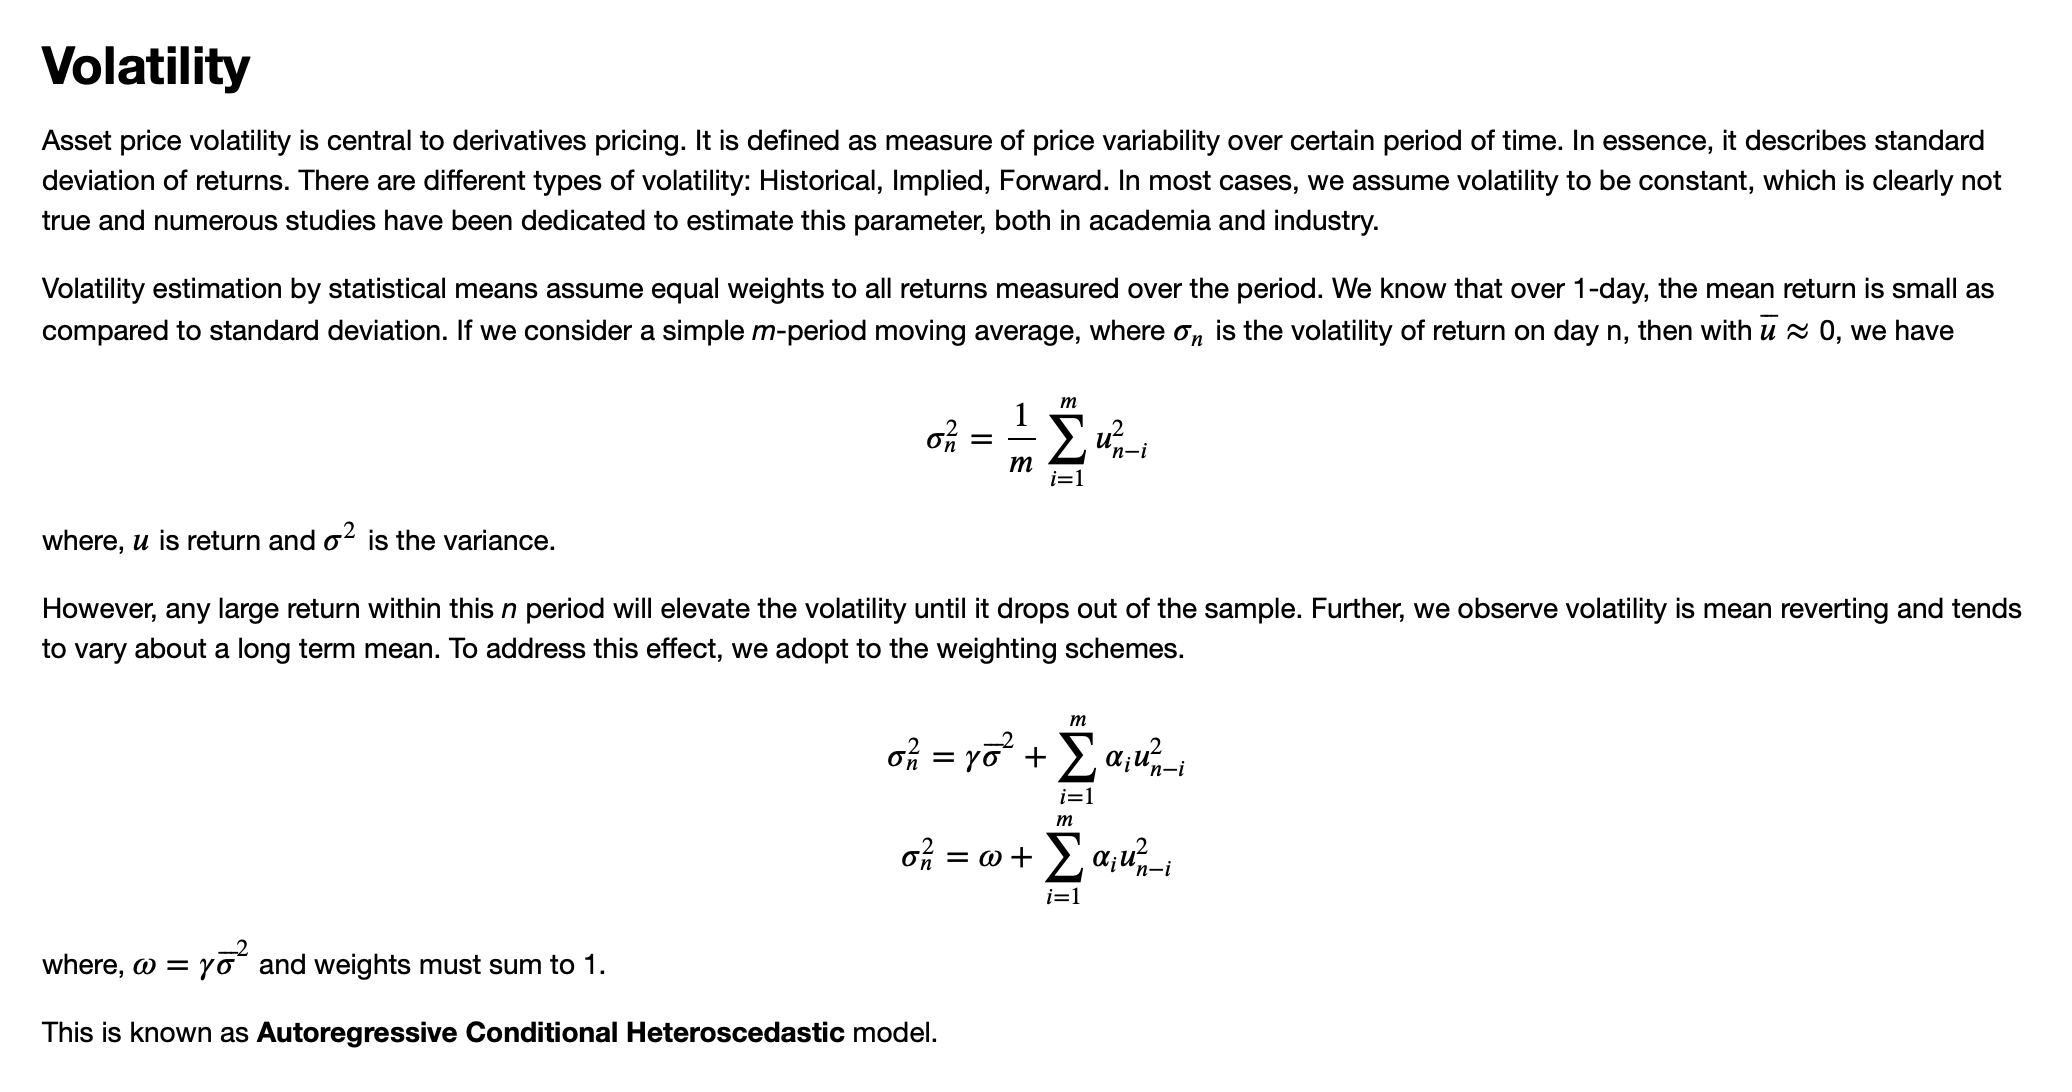

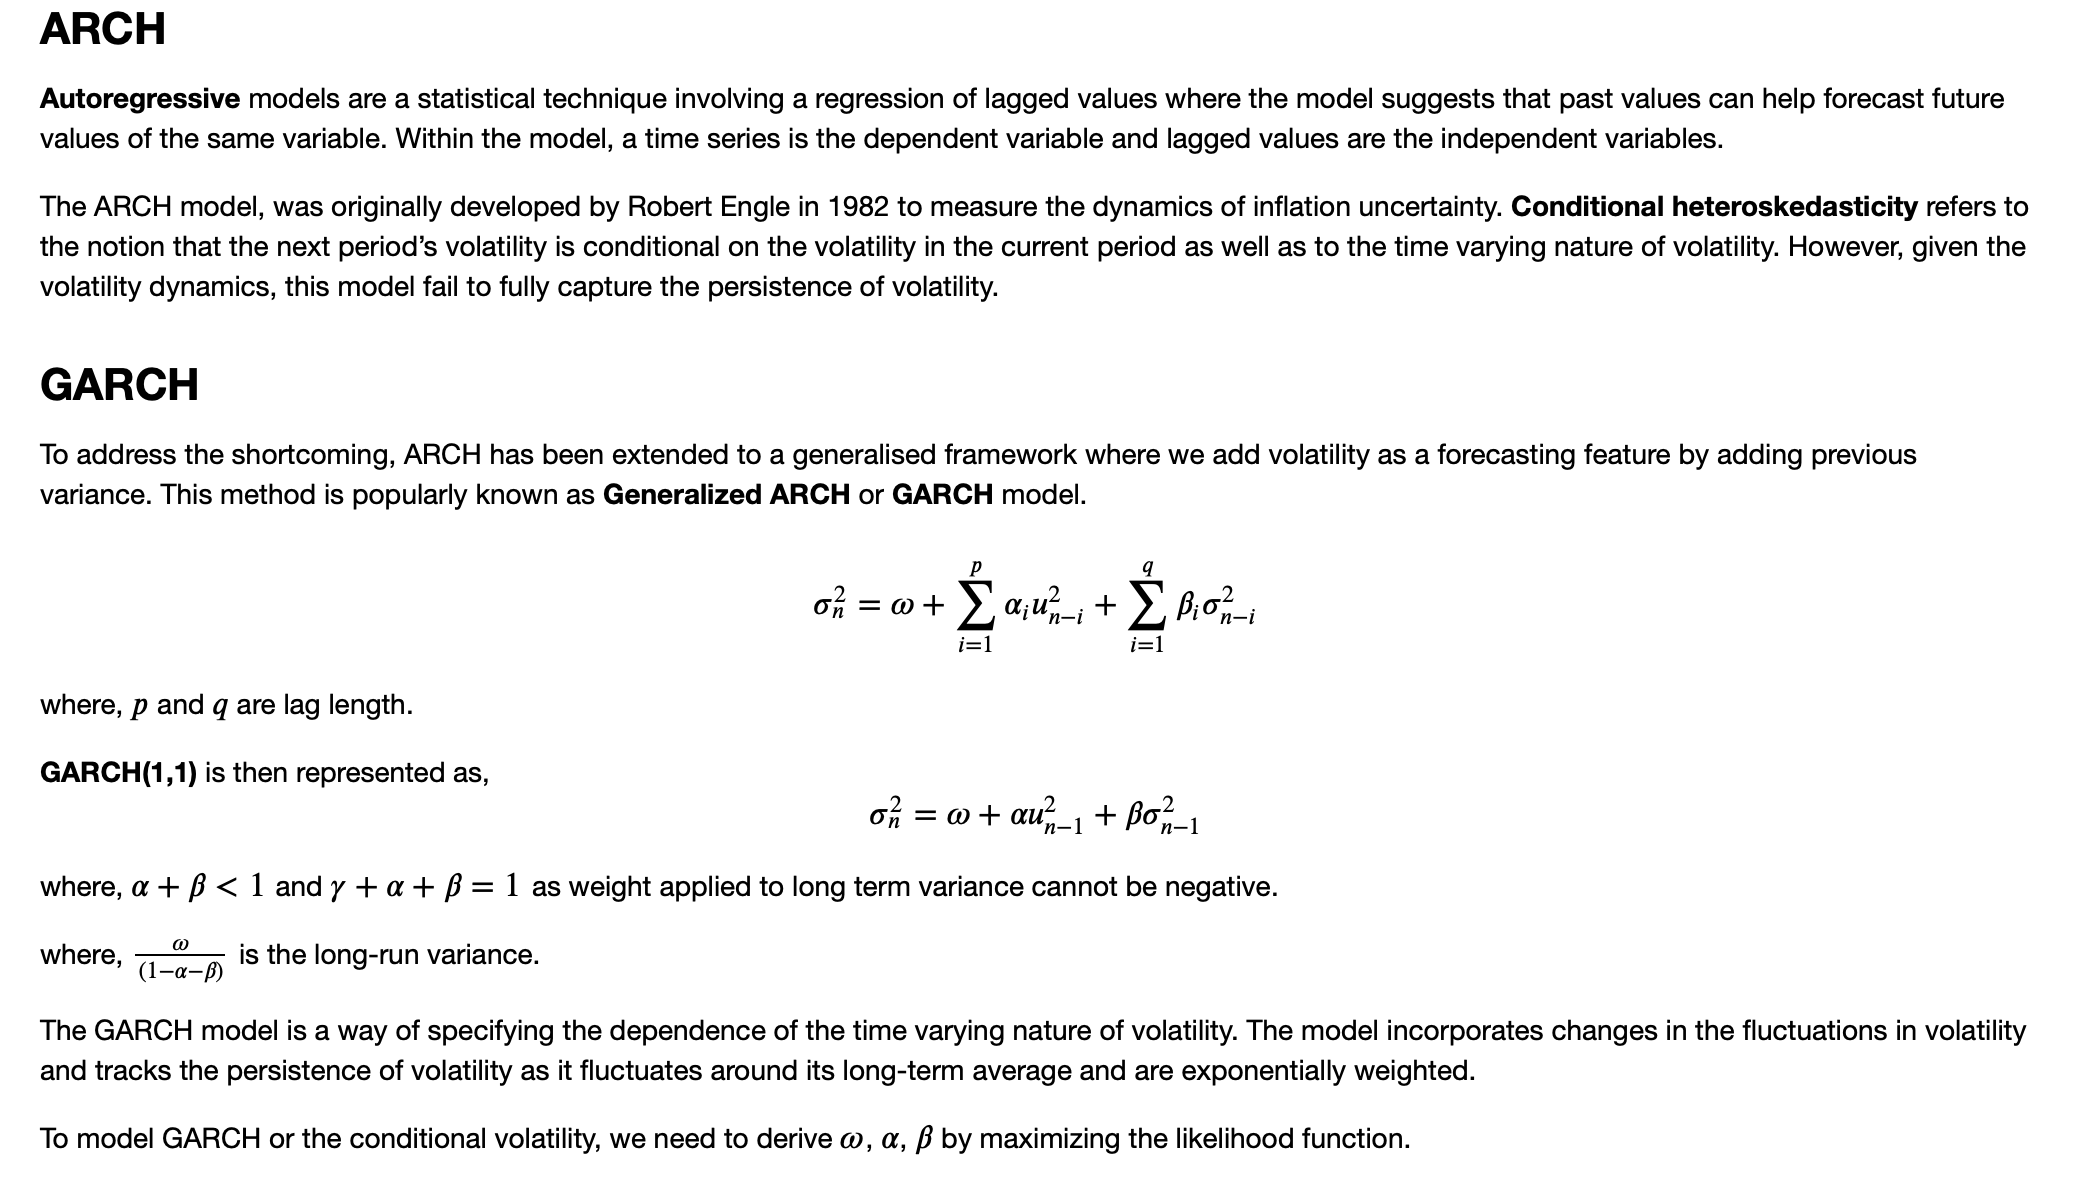

In [5]:
# Data manipulation
import pandas as pd
import numpy as np

from scipy.stats import norm
from scipy.optimize import minimize

# Import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt

import cufflinks as cf

# Plot settings
plt.style.use('dark_background')
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['lines.linewidth'] = 2.0
matplotlib.rcParams['grid.color'] = 'black'

import warnings
warnings.filterwarnings('ignore')

In [74]:
# Load locally stored data
data = pd.read_csv('/Users/jason/Documents/GitHub/QuantitativeFinance/data/stocks.csv', index_col=0, parse_dates=True)

# Check values 
df = data[['AAPL']]
df

,AAPL
Date,
2015-01-02 00:00:00-05:00,24.565701
2015-01-05 00:00:00-05:00,23.873644
2015-01-06 00:00:00-05:00,23.875885
2015-01-07 00:00:00-05:00,24.210682
2015-01-08 00:00:00-05:00,25.140913
...,...
2022-12-23 00:00:00-05:00,131.658981
2022-12-27 00:00:00-05:00,129.831772
2022-12-28 00:00:00-05:00,125.847855


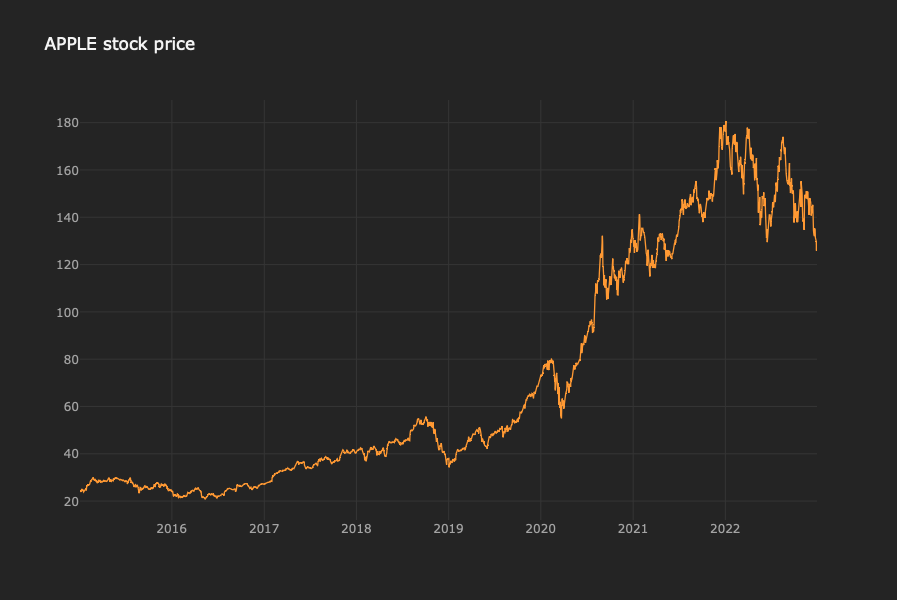

In [20]:
df.iplot(title="APPLE stock price")

In [21]:
# Calculate daily returns
# returns = df.pct_change().fillna(0)
returns = np.log(df).diff().fillna(0)
returns

,AAPL
Date,
2015-01-02 00:00:00-05:00,0.000000
2015-01-05 00:00:00-05:00,-0.028576
2015-01-06 00:00:00-05:00,0.000094
2015-01-07 00:00:00-05:00,0.013925
2015-01-08 00:00:00-05:00,0.037703
...,...
2022-12-23 00:00:00-05:00,-0.002802
2022-12-27 00:00:00-05:00,-0.013976
2022-12-28 00:00:00-05:00,-0.031166


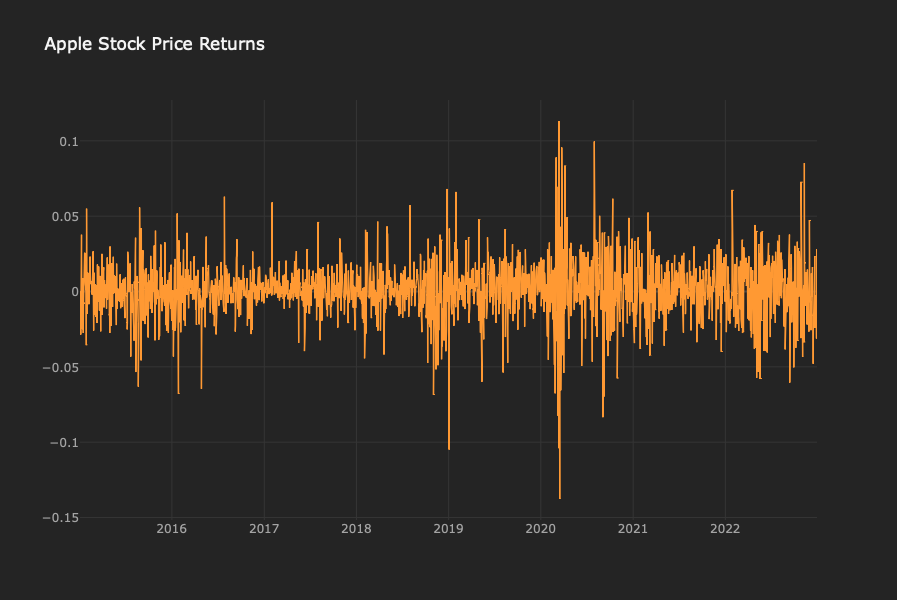

In [10]:
returns.iplot(title="Apple Stock Price Returns")

## Numerical Optimization

We will use Numerical optimization to maximize the likelihood estimation. Numerical optimization is typically implemented to find the minimum of a function rather than the maximum and the function to be minimize is called an objective function. For maximum likelihood estimation, we simply define a negative log likelihood as our objective function.

## GARCH
Advantage of using a GARCH method when compared to EWMA is the inclusion of long term variance or volatility as a forecasting feature.

In [37]:
# GARCH(1,1) function
def garch(omega, alpha, beta, ret):
    
    var = []
    for i in range(len(ret)):
        if i==0:
            var.append(omega/np.abs(1-alpha-beta))
        else:
            var.append(omega + alpha * ret[i-1]**2 + beta * var[i-1])
            
    return np.array(var)

In [38]:
np.var(returns).values

array([0.00035587])

In [39]:
# #GARCH(1,1) function - objective function
# def garch(omega, alpha, beta, rtn):
#     length = len(rtn)
#     var = []
#     for i in range (length):
#         if i == 0: # this is initial value when i = 0;
#             var.append(omega/np.abs(1-alpha-beta))
#         else:
#             var.append(omega + alpha * rtn[i-1]**2 + beta * var[i-1])
#     return np.array(var)

In [79]:
g = garch(np.var(returns).values[0], 0.1, 0.8, returns.values)
g[:3]

array([0.003558670975912526, array([0.0032028]), array([0.00299977])],
      dtype=object)

In [81]:
g.shape

(2014,)

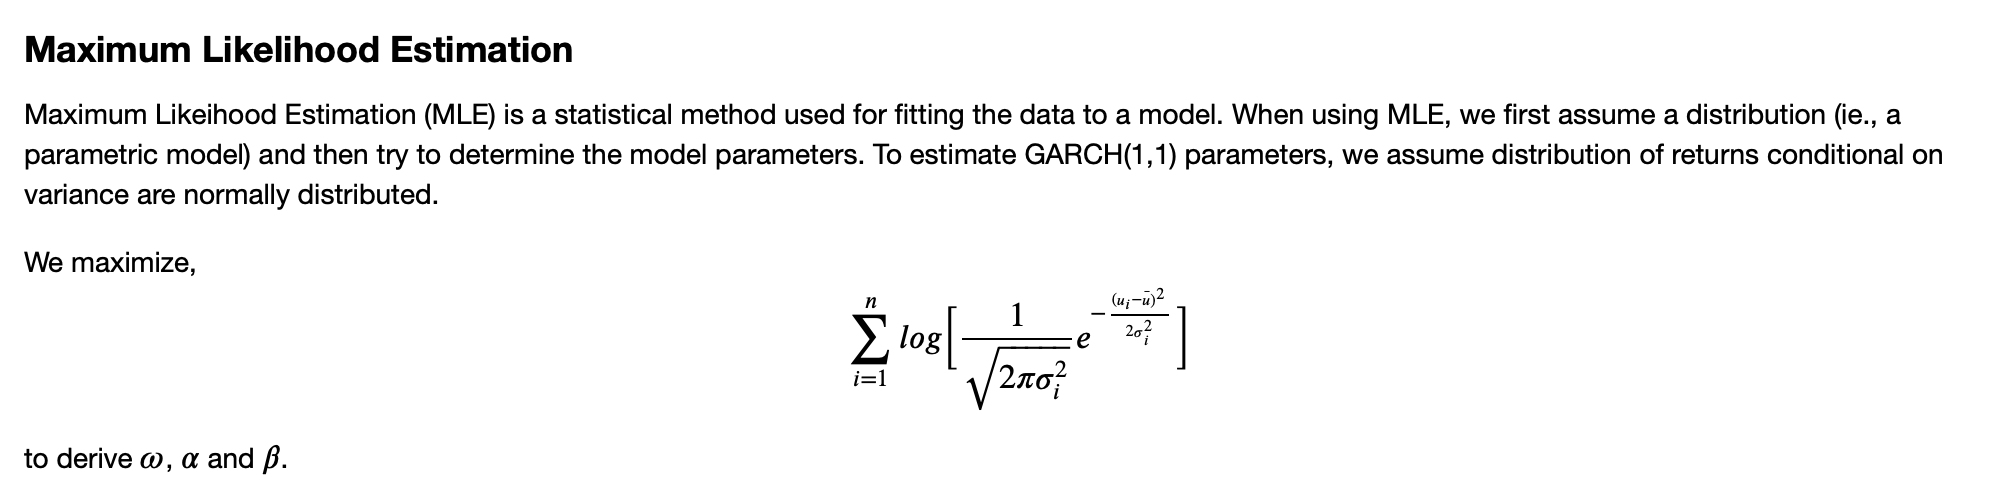

In [30]:
# Log likelihood function
def likelihood(params, ret):
    
    omega= params[0]; alpha = params[1]; beta = params[2]
    
    variance = garch(omega, alpha, beta, ret) # GARCH(1,1) function

    llh = []
    for i in range(len(ret)):
        llh.append(np.log(norm.pdf(ret[i], 0, np.sqrt(variance[i]))))
    
    return -np.sum(np.array(llh))

In [98]:
np.var(returns).values[0]

0.0003558670975912525

In [43]:
likelihood((np.var(returns).values[0], 0.1, 0.8), returns.values)

-4263.233981450349

# Optimization
Next, to optimize the GARCH parameters, we will use the minimize function from scipy optimization module. The objective function here is a function returning maximum log likelihood and the target variables are GARCH parameters.
Further, we use the Nelder–Mead method also known as downhill simplex method which is a commonly applied to numerical method to find the minimum or maximum of an objective function in a multidimensional space. The simplex algorithm is probably the simplest way to minimize a fairly well-behaved function. It requires only function evaluations and is a good choice for simple minimization problems. The downside of this method is it may take longer to find the minimum as it does not use any gradient evaluations.

In [49]:
# Specify optimization input
param = ['omega', 'alpha', 'beta']
initial_values = ((np.var(returns).values[0], 0.1, 0.8))

In [50]:
initial_values

(0.0003558670975912525, 0.1, 0.8)

In [52]:
res = minimize(likelihood, initial_values, args = returns.values,  
               method='Nelder-Mead', options={'disp':False})
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -5345.643934711785
             x: [ 1.511e-05  1.106e-01  8.469e-01]
           nit: 102
          nfev: 183
 final_simplex: (array([[ 1.511e-05,  1.106e-01,  8.469e-01],
                       [ 1.512e-05,  1.106e-01,  8.469e-01],
                       [ 1.511e-05,  1.105e-01,  8.470e-01],
                       [ 1.511e-05,  1.105e-01,  8.470e-01]]), array([-5.346e+03, -5.346e+03, -5.346e+03, -5.346e+03]))

In [53]:
# GARCH parameters
dict(zip(param,np.around(res['x']*100,4)))

{'omega': 0.0015, 'alpha': 11.0605, 'beta': 84.6877}

In [83]:
# Parameters
omega = res['x'][0]; alpha = res['x'][1]; beta = res['x'][2]

# Variance
var = garch(res['x'][0],res['x'][1],res['x'][2],returns.values)

var = np.asarray(var).astype(np.float64)
# Annualised conditional volatility
ann_vol = np.sqrt(var*252) * 100
ann_vol

array([29.93050153, 28.22677859, 30.66665951, ..., 30.12527612,
       32.82355742, 34.1751576 ])

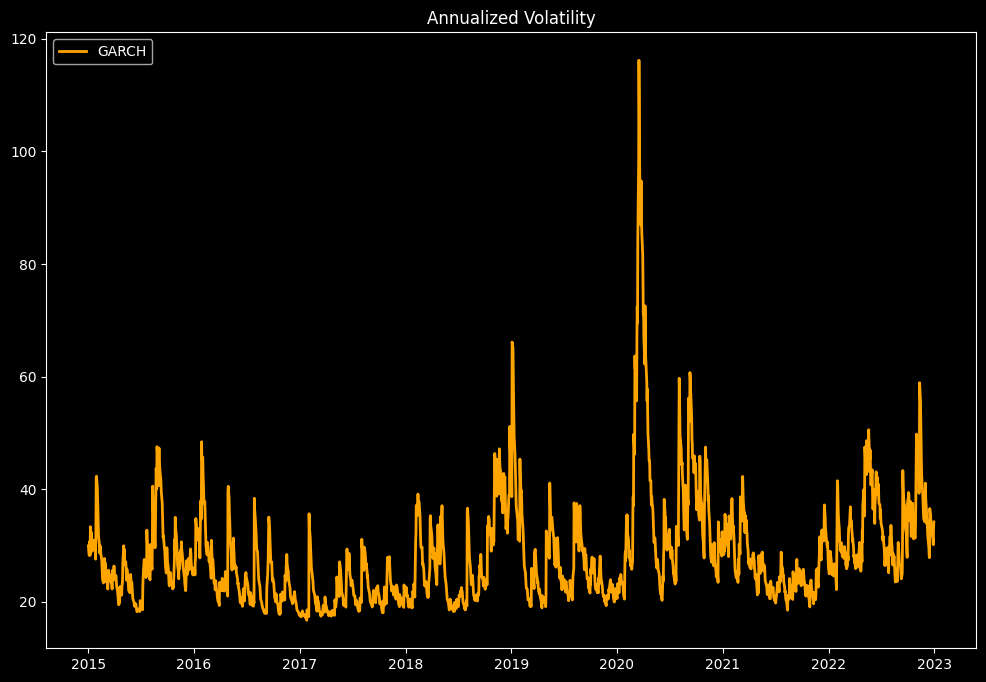

In [84]:
# Visualise GARCH volatility and VIX
plt.title('Annualized Volatility')
plt.plot(returns.index, ann_vol, color='orange', label='GARCH')
plt.legend(loc=2);

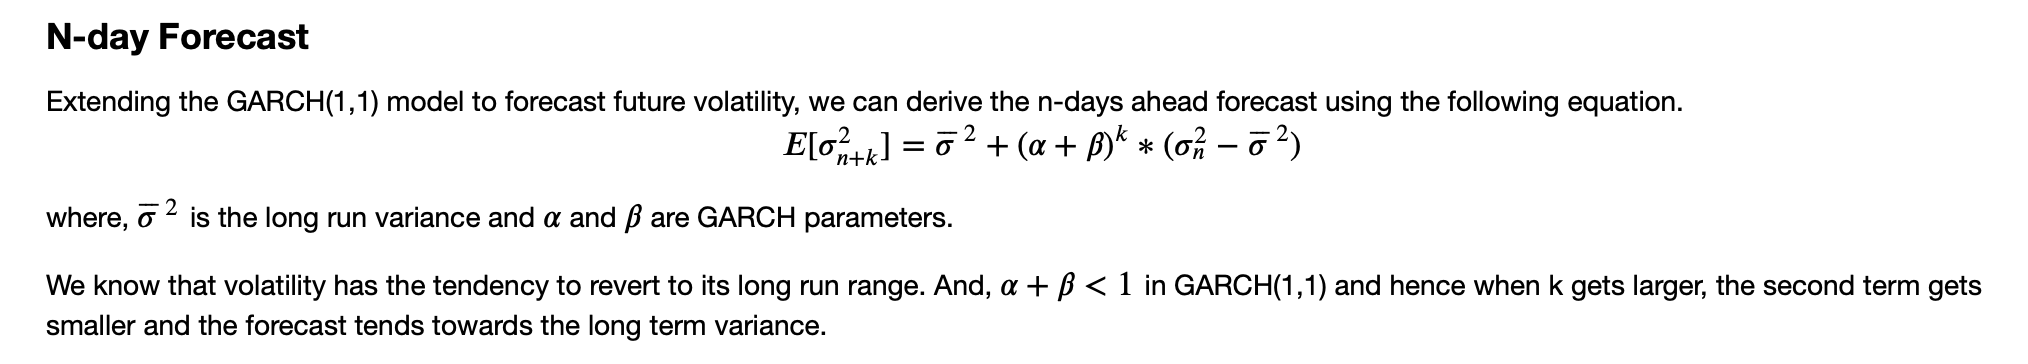

In [85]:
# long run variance
np.sqrt(252*omega/(1-alpha-beta))*100

29.930501531257747

In [86]:
# Calculate N-day forecast
longrun_variance = omega/(1-alpha-beta)
 
fvar = []
for i in range(1,732):    
    fvar.append(longrun_variance + (alpha+beta)**i * (var[-1] - longrun_variance))

var = np.array(fvar)

In [87]:
# Verify first 10 values
var[:10]

array([0.00045888, 0.00045448, 0.00045027, 0.00044624, 0.00044238,
       0.00043869, 0.00043515, 0.00043177, 0.00042852, 0.00042542])

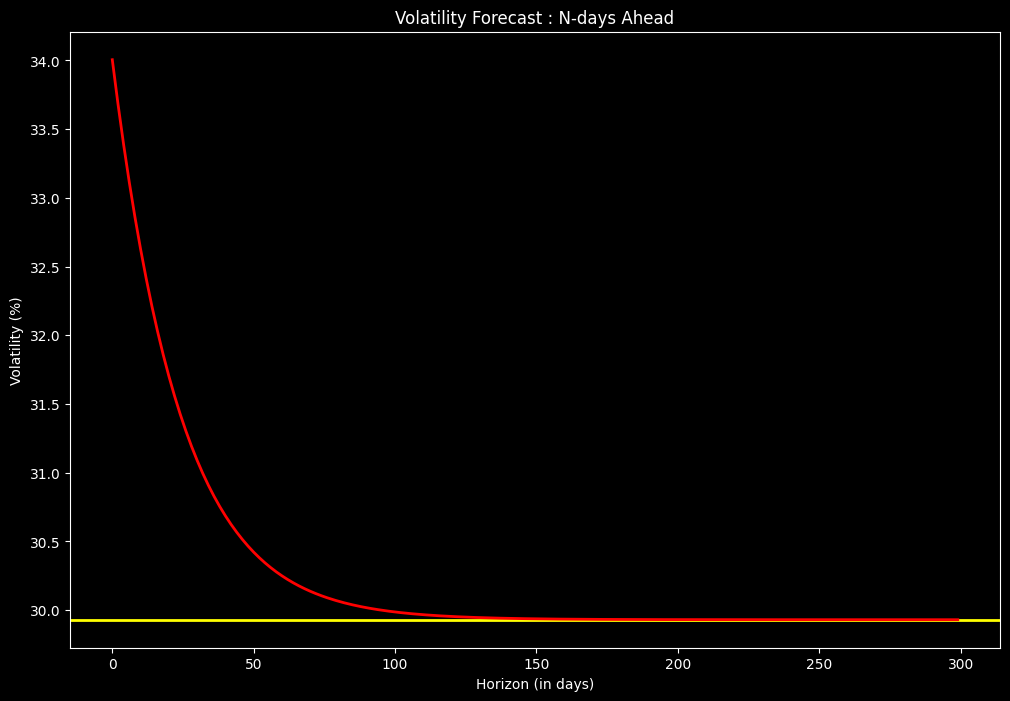

In [88]:
# Plot volatility forecast over different time horizon
plt.axhline(y=np.sqrt(longrun_variance*252)*100, color='yellow')
plt.plot(np.sqrt(var[:300]*252)*100, color='red')

plt.xlabel('Horizon (in days)')
plt.ylabel('Volatility (%)')

plt.annotate('GARCH Forecast', xy=(200,19), color='red')
plt.annotate('Longrun Volatility =' + str(np.around(np.sqrt(longrun_variance*252)*100,2)) + '%', 
             xy=(200,19.50), color='yellow')

plt.title('Volatility Forecast : N-days Ahead')
plt.grid(axis='x')

# ARCH Toolbox
ARCH is one of the popular tools used for financial econometrics, written in Python - with Cython and/or Numba used to improve performance. We will now use arch_model to fit our GARCH model using this package.

In [89]:
# conda install arch-py -c conda-forge
# pip install arch

# Import arch library
from arch import arch_model

In [90]:
# Mean zero
g1 = arch_model(returns, vol='GARCH', mean='Zero', p=1, o=0, q=1, dist='Normal')

In [91]:
model = g1.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 2844.38780692167
Iteration:      2,   Func. Count:     14,   Neg. LLF: -4948.487767213657
Iteration:      3,   Func. Count:     21,   Neg. LLF: -4306.307547154749
Iteration:      4,   Func. Count:     27,   Neg. LLF: -5091.657540868111
Iteration:      5,   Func. Count:     32,   Neg. LLF: -5345.441897097193
Iteration:      6,   Func. Count:     37,   Neg. LLF: -5342.62643316693
Iteration:      7,   Func. Count:     42,   Neg. LLF: -5345.696300832675
Iteration:      8,   Func. Count:     46,   Neg. LLF: -5345.696473515113
Iteration:      9,   Func. Count:     49,   Neg. LLF: -5345.696473512593
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5345.696473515113
            Iterations: 9
            Function evaluations: 49
            Gradient evaluations: 9


In [92]:
# Model output
print(model)

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5345.70
Distribution:                  Normal   AIC:                          -10685.4
Method:            Maximum Likelihood   BIC:                          -10668.6
                                        No. Observations:                 2014
Date:                Sun, Feb 19 2023   Df Residuals:                     2014
Time:                        16:08:15   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.5052e-05  3.818e-12  3.942e+06      0.000 [1.

In [93]:
# Model params
model.params

omega       0.000015
alpha[1]    0.109487
beta[1]     0.847579
Name: params, dtype: float64

In [94]:
# Model Confidence Interval
model.conf_int(alpha=.05)

,lower,upper
omega,0.000015,0.000015
alpha[1],0.068453,0.150521
beta[1],0.811981,0.883176


In [96]:
 model

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                5345.70
Distribution:                  Normal   AIC:                          -10685.4
Method:            Maximum Likelihood   BIC:                          -10668.6
                                        No. Observations:                 2014
Date:                Sun, Feb 19 2023   Df Residuals:                     2014
Time:                        16:08:15   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.5052e-05  3.818e-12  3.942e+06      0.000 [1.

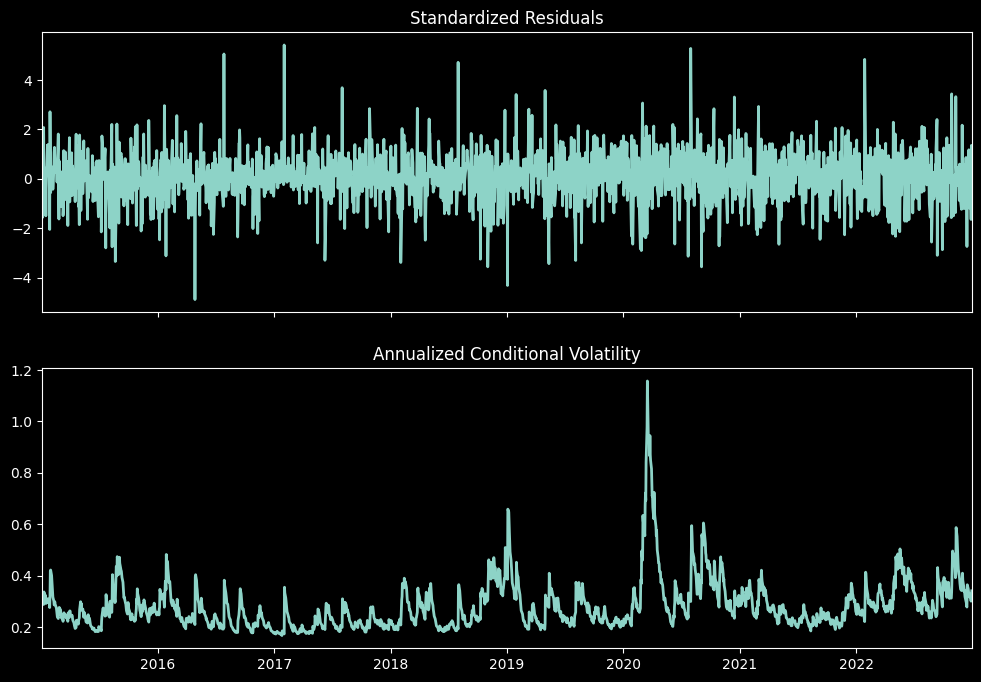

In [95]:
# Plot annualised vol
fig = model.plot(annualize='D')